In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle

In [2]:
pip install scikit-learn==1.6.1


Note: you may need to restart the kernel to use updated packages.


In [3]:
#load dataset
df = pd.read_csv(r'C:\Users\SRINIVAS\Downloads\taxi_fare.csv')


In [4]:
#Basic Data Inspection
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())
print(df.duplicated().sum())


(212345, 18)
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
t

In [5]:

# Feature Engineering
# Haversine Formula
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    return 6371 * c

df['trip_distance'] = df.apply(lambda row: haversine(
    row['pickup_longitude'], row['pickup_latitude'],
    row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [6]:
# Datetime features
df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['am_pm'] = df['pickup_hour'].apply(lambda x: 'am' if x < 12 else 'pm')
df['is_night'] = df['pickup_hour'].apply(lambda x: 1 if x <= 5 or x >= 22 else 0)

In [7]:
# Data Cleaning
# Drop rows with negative or zero fare and distance
df = df[(df['trip_distance'] > 0) & (df['total_amount'] > 0)]
df = df[df['passenger_count'] > 0]

In [8]:
# Log transform
df['log_total_amount'] = np.log1p(df['total_amount'])

In [9]:
# Encode categorical
df = pd.get_dummies(df, columns=['am_pm', 'payment_type'], drop_first=True)


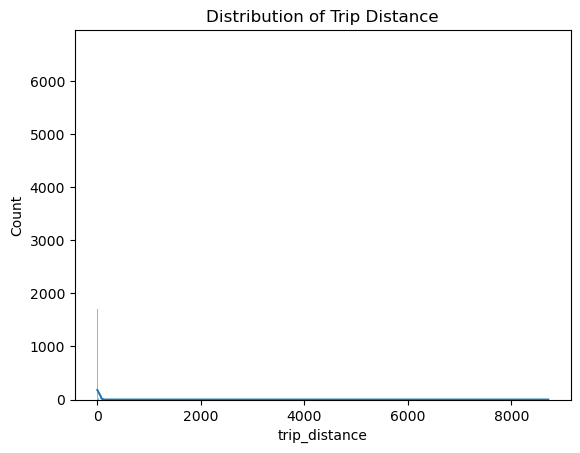

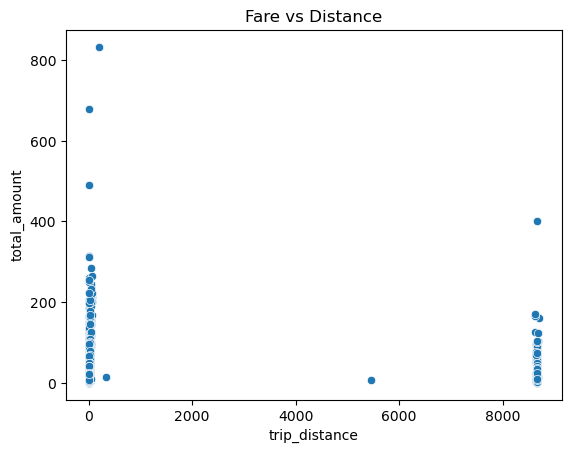

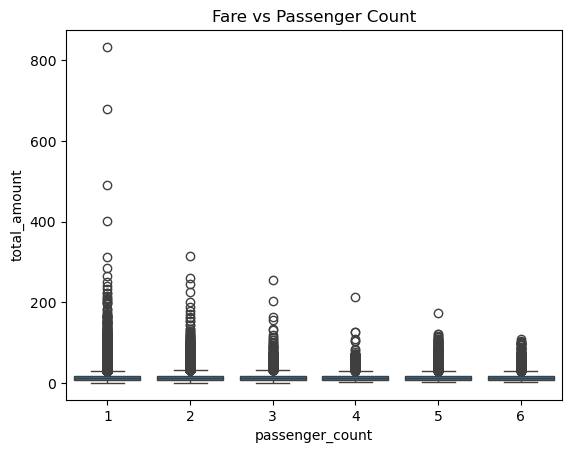

In [10]:
#  EDA
sns.histplot(df['trip_distance'], kde=True)
plt.title('Distribution of Trip Distance')
plt.show()

sns.scatterplot(x='trip_distance', y='total_amount', data=df)
plt.title('Fare vs Distance')
plt.show()

sns.boxplot(x='passenger_count', y='total_amount', data=df)
plt.title('Fare vs Passenger Count')
plt.show()

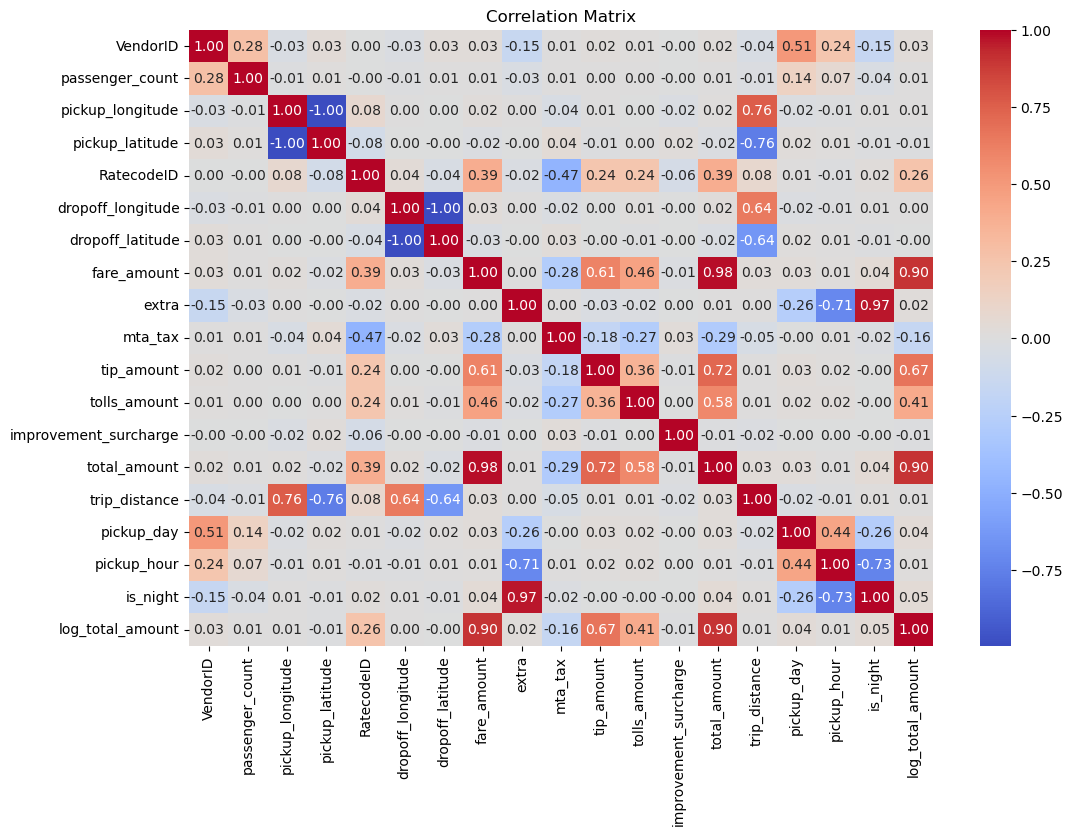

In [11]:
# Only select numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [12]:
# Feature Selection
X = df[['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_day', 'is_night'] + 
       [col for col in df.columns if 'payment_type' in col or 'am_pm' in col]]
y = df['log_total_amount']

In [13]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined

for name, model in models.items():
    model.fit(X_train, y_train)              # Train the model
    preds = model.predict(X_test)            # Make predictions
    mse = mean_squared_error(y_test, preds)  # Evaluate metrics
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    print(f"{name}: R2 = {r2:.2f}, RMSE = {rmse:.2f}")


Linear: R2 = 0.06, RMSE = 0.54
Ridge: R2 = 0.06, RMSE = 0.54
Lasso: R2 = 0.00, RMSE = 0.56
RandomForest: R2 = 0.83, RMSE = 0.23
GradientBoosting: R2 = 0.86, RMSE = 0.21


In [16]:
#  Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='r2')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)

Best Parameters: {'max_depth': 10, 'n_estimators': 100}


In [17]:
best_model = None
lowest_rmse = float('inf')

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    if rmse < lowest_rmse:
        lowest_rmse = rmse
        best_model = model




In [19]:
# Save Best Model
best_model = grid.best_estimator_
pickle.dump(best_model, open('fare_predictor.pkl', 'wb'))

In [26]:
best_model

RandomForestRegressor(max_depth=10)

In [24]:
mkdir models


In [25]:
import pickle

# Train your best model
best_model.fit(X_train, y_train)

# Save it
with open('models/fare_predictor.pkl', 'wb') as f:
    pickle.dump(best_model, f)


In [27]:
import os
print(os.path.exists('models/fare_predictor.pkl'))  # Should be True if it exists


True
